# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [3]:
data = pd.read_csv("/content/drive/My Drive/Homework 4/Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

158138    My client is looking for a fulltime, target an...
146023    We are currently recruiting for the following ...
201406    Evaluation Advisor **** London or **** Nationa...
Name: FullDescription, dtype: object

In [4]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
12880,66579111,Debt Recovery Paralegal (Undefended),KT/BCR/****Leading West Midlands Law firm requ...,Birmingham,Birmingham,NaN,permanent,NaN,Admin Jobs,15k - 20k,17500,simplyofficejobs.co.uk,9.770013
63419,68703948,Home Manager Wiltshire,Home Manager My client is currently looking fo...,"Chippenham, Wiltshire Wiltshire South West",Chippenham,NaN,permanent,Hammond Recruitment,Healthcare & Nursing Jobs,25000 - 35000 per annum,30000,totaljobs.com,10.308986
235910,72547317,Oracle Reporting Manager,"Oracle, Finance, Oracle R**** , Financial Repo...","Manchester, Greater Manchester",Manchester,NaN,permanent,Catch Resource Management,IT Jobs,37000 - 45000/annum,41000,cv-library.co.uk,10.621352


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [5]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


In [8]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
5,13179816,engineering systems analyst water industry,engineering systems analyst water industry loc...,"Dorking, Surrey, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20K to 30K,25000,cv-library.co.uk,10.126671
6,14131336,senior subsea pipeline integrity engineer,a globally renowned engineering and training c...,"Aberdeen, Borders",UK,NaN,permanent,Indigo 21 Ltd,Engineering Jobs,50000 - 100000/annum,75000,cv-library.co.uk,11.225257
7,14663196,recruitment consultant industrial / commercial...,this is a live vacancy not a generic advertise...,"MANCHESTER, Greater Manchester",Manchester,NaN,permanent,Code Blue Recruitment,HR & Recruitment Jobs,18000 - 26000/annum TO 26K BASIC + COMM + BENS,22000,cv-library.co.uk,9.998843
8,14663197,recruitment consultant construction / technica...,this is an exceptional opportunity to join a c...,"LEEDS, West Yorkshire",Leeds,NaN,permanent,Code Blue Recruitment,HR & Recruitment Jobs,18000 - 28000/annum 18 - 28K BASIC + COMM + BENS,23000,cv-library.co.uk,10.043293
9,15395797,subsea cables engineer,a subsea engineering company is looking for an...,"Aberdeen, UK",Aberdeen,NaN,permanent,Indigo 21 Ltd,Engineering Jobs,70000 - 100000/annum,85000,cv-library.co.uk,11.350418


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
# <YOUR CODE HERE>
token_counts_1 = Counter(" ".join(data['Title']).split(" "))
token_counts_2 = Counter(" ".join(data['FullDescription']).split(" "))
token_counts = token_counts_1 + token_counts_2

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

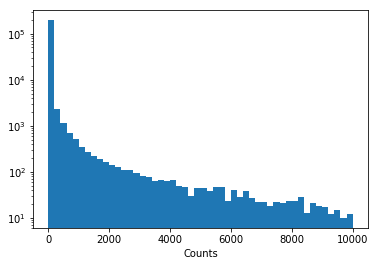

In [11]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = []
for v in token_counts.items():
    if v[1] >= min_count:
        tokens.append(v[0])

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
token_to_id = dict(enumerate(tokens))
token_to_id = dict([[v,k] for k,v in token_to_id.items()])
token_to_id

{'UNK': 0,
 'PAD': 1,
 'engineering': 2,
 'systems': 3,
 'analyst': 4,
 'stress': 5,
 'engineer': 6,
 'glasgow': 7,
 'modelling': 8,
 'and': 9,
 'simulation': 10,
 '/': 11,
 'mathematical': 12,
 'modeller': 13,
 'pioneer': 14,
 ',': 15,
 'water': 16,
 'industry': 17,
 'senior': 18,
 'subsea': 19,
 'pipeline': 20,
 'integrity': 21,
 'recruitment': 22,
 'consultant': 23,
 'industrial': 24,
 'commercial': 25,
 'construction': 26,
 'technical': 27,
 'trades': 28,
 'labour': 29,
 'cables': 30,
 'trainee': 31,
 'mortgage': 32,
 'advisor': 33,
 'east': 34,
 'midlands': 35,
 'project': 36,
 'pharmaceutical': 37,
 'principal': 38,
 'composite': 39,
 'fatigue': 40,
 'damage': 41,
 'tolerance': 42,
 'chef': 43,
 'de': 44,
 'partie': 45,
 'award': 46,
 'winning': 47,
 'restaurant': 48,
 'excellent': 49,
 'tips': 50,
 'quality': 51,
 'controls': 52,
 'dining': 53,
 'live': 54,
 'in': 55,
 'share': 56,
 'of': 57,
 'c': 58,
 'i': 59,
 'design': 60,
 'lead': 61,
 'engineers': 62,
 '(': 63,
 ')': 64,
 

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [21]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  360,  3030,  1166,    95,   618,   858,  2157,  1166,  3225,
          1527],
        [21217,  1464,  1032,    57,   142,  1588,  2077,    55,   142,
           743],
        [  558,  2133,   561,  2310,   944,    73,   561,   177,  6216,
           111]], dtype=int32),
 'Log1pSalary': array([ 9.629116 , 11.350418 , 10.2036295], dtype=float32),
 'Title': array([[  95,  618,  858,    1],
        [1130, 1131,    1,    1],
        [2310, 9761,  534, 1324]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

In [50]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

In [52]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categ_encoder = nn.Sequential(nn.Linear(n_cat_features, 256),
                                          nn.ReLU(),
                                          nn.Linear(256, 64),
                                          nn.ReLU())
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(192, 192)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        x = self.output(joint_h)
        outputs = torch.Tensor(torch.log(1 + x.cpu())) 
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return outputs[:, 0]

In [0]:
model = FullNetwork()
model = model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [60]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:



	Loss:	48.91801
	MAE:	12301.50042



Validation:



	Loss:	28.75726
	MAE:	12470.60224



Training:



	Loss:	21.59119
	MAE:	12582.91406



Validation:



	Loss:	16.10394
	MAE:	12316.72522



Training:



	Loss:	13.02581
	MAE:	12201.95865



Validation:



	Loss:	10.48326
	MAE:	12071.03315



Training:



	Loss:	8.79694
	MAE:	12044.04285



Validation:



	Loss:	7.22158
	MAE:	11732.78481



Training:



	Loss:	6.16347
	MAE:	11678.78897



Validation:



	Loss:	5.14768
	MAE:	11311.88294



Training:



	Loss:	4.42822
	MAE:	11125.33628



Validation:



	Loss:	3.77482
	MAE:	10829.92145



Training:



	Loss:	3.24956
	MAE:	10468.01453



Validation:



	Loss:	2.83103
	MAE:	10305.64762



Training:



	Loss:	2.44647
	MAE:	9869.77735



Validation:



	Loss:	2.15958
	MAE:	9751.87199



Training:



	Loss:	1.90237
	MAE:	9416.08293



Validation:



	Loss:	1.67015
	MAE:	9179.67477



Training:



	Loss:	1.48547
	MAE:	8928.36678



Validation:



	Loss:	1.30977
	MAE:	8602.79280



Training:



	Loss:	1.19173
	MAE:	8429.13840



Validation:



	Loss:	1.03956
	MAE:	8028.67041



Training:



	Loss:	0.96446
	MAE:	7978.88604



Validation:



	Loss:	0.83436
	MAE:	7474.48909



Training:



	Loss:	0.75398
	MAE:	7197.79483



Validation:



	Loss:	0.68336
	MAE:	6980.93857



Training:



	Loss:	0.63176
	MAE:	6820.02315



Validation:



	Loss:	0.56706
	MAE:	6535.14924



Training:



	Loss:	0.51789
	MAE:	6308.14057



Validation:



	Loss:	0.48017
	MAE:	6155.16753



Training:



	Loss:	0.44533
	MAE:	6020.29561



Validation:



	Loss:	0.41352
	MAE:	5826.27879



Training:



	Loss:	0.37457
	MAE:	5538.53627



Validation:



	Loss:	0.36444
	MAE:	5558.15154



Training:



	Loss:	0.33473
	MAE:	5333.61776



Validation:



	Loss:	0.32592
	MAE:	5328.21973



Training:



	Loss:	0.31317
	MAE:	5270.40776



Validation:



	Loss:	0.29661
	MAE:	5139.47146



Training:



	Loss:	0.29275
	MAE:	5220.40346



Validation:



	Loss:	0.27269
	MAE:	4974.78199



Training:



	Loss:	0.26694
	MAE:	4904.11975



Validation:



	Loss:	0.25659
	MAE:	4857.61101



Training:



	Loss:	0.24397
	MAE:	4716.48597



Validation:



	Loss:	0.24442
	MAE:	4764.17771



Training:



	Loss:	0.24405
	MAE:	4758.89443



Validation:



	Loss:	0.23499
	MAE:	4688.65480



Training:



	Loss:	0.23521
	MAE:	4727.55701



Validation:



	Loss:	0.22763
	MAE:	4627.17190



Training:



	Loss:	0.23038
	MAE:	4664.37966



Validation:



	Loss:	0.22186
	MAE:	4576.70239



Training:



	Loss:	0.21791
	MAE:	4526.59768



Validation:



	Loss:	0.21758
	MAE:	4537.54242



Training:



	Loss:	0.21138
	MAE:	4481.29387



Validation:



	Loss:	0.21414
	MAE:	4505.07287



Training:



	Loss:	0.21466
	MAE:	4503.31517



Validation:



	Loss:	0.21141
	MAE:	4478.50041



Training:



	Loss:	0.20575
	MAE:	4422.58864



Validation:



	Loss:	0.20891
	MAE:	4453.97402



Training:



	Loss:	0.20849
	MAE:	4386.04980



Validation:



	Loss:	0.20701
	MAE:	4435.30182



Training:



	Loss:	0.21252
	MAE:	4497.22672



Validation:



	Loss:	0.20501
	MAE:	4415.56173



Training:



	Loss:	0.20822
	MAE:	4472.43676



Validation:



	Loss:	0.20316
	MAE:	4396.92173



Training:



	Loss:	0.20565
	MAE:	4427.42835



Validation:



	Loss:	0.20137
	MAE:	4378.70473



Training:



	Loss:	0.21276
	MAE:	4516.32618



Validation:



	Loss:	0.19957
	MAE:	4359.94009



Training:



	Loss:	0.19876
	MAE:	4374.49644



Validation:



	Loss:	0.19787
	MAE:	4342.36326



Training:



	Loss:	0.19860
	MAE:	4350.70559



Validation:



	Loss:	0.19625
	MAE:	4325.31493



Training:



	Loss:	0.19589
	MAE:	4285.36509



Validation:



	Loss:	0.19456
	MAE:	4307.72777



Training:



	Loss:	0.19373
	MAE:	4291.52079



Validation:



	Loss:	0.19290
	MAE:	4289.83600



Training:



	Loss:	0.19631
	MAE:	4268.80544



Validation:



	Loss:	0.19131
	MAE:	4272.91293



Training:



	Loss:	0.18910
	MAE:	4239.58794



Validation:



	Loss:	0.18981
	MAE:	4256.67983



Training:



	Loss:	0.19367
	MAE:	4383.30030



Validation:



	Loss:	0.18832
	MAE:	4240.32295



Training:



	Loss:	0.17962
	MAE:	4133.58241



Validation:



	Loss:	0.18688
	MAE:	4224.45785



Training:



	Loss:	0.18065
	MAE:	4103.68408



Validation:



	Loss:	0.18555
	MAE:	4209.94680



Training:



	Loss:	0.19572
	MAE:	4319.64993



Validation:



	Loss:	0.18400
	MAE:	4192.68118



Training:



	Loss:	0.18975
	MAE:	4261.14558



Validation:



	Loss:	0.18259
	MAE:	4176.77175



Training:



	Loss:	0.19033
	MAE:	4273.77104



Validation:



	Loss:	0.18124
	MAE:	4161.68202



Training:



	Loss:	0.17918
	MAE:	4201.94257



Validation:



	Loss:	0.17995
	MAE:	4146.78205



Training:



	Loss:	0.18821
	MAE:	4226.83789



Validation:



	Loss:	0.17861
	MAE:	4131.27299



Training:



	Loss:	0.18033
	MAE:	4143.71645



Validation:



	Loss:	0.17737
	MAE:	4117.11906



Training:



	Loss:	0.18840
	MAE:	4255.59576



Validation:



	Loss:	0.17624
	MAE:	4104.22476



Training:



	Loss:	0.18147
	MAE:	4186.11114



Validation:



	Loss:	0.17516
	MAE:	4091.61712



Training:



	Loss:	0.17643
	MAE:	4116.27699



Validation:



	Loss:	0.17390
	MAE:	4077.11590



Training:



	Loss:	0.18086
	MAE:	4229.26727



Validation:



	Loss:	0.17282
	MAE:	4064.64194



Training:



	Loss:	0.17440
	MAE:	4017.44825



Validation:



	Loss:	0.17176
	MAE:	4052.16835



Training:



	Loss:	0.17489
	MAE:	4054.23535



Validation:



	Loss:	0.17081
	MAE:	4041.03602



Training:



	Loss:	0.17792
	MAE:	4040.87308



Validation:



	Loss:	0.16988
	MAE:	4030.24582



Training:



	Loss:	0.16426
	MAE:	4025.49914



Validation:



	Loss:	0.16899
	MAE:	4019.12165



Training:



	Loss:	0.16877
	MAE:	3998.94120



Validation:



	Loss:	0.16820
	MAE:	4009.50799



Training:



	Loss:	0.17332
	MAE:	4116.42627



Validation:



	Loss:	0.16742
	MAE:	4000.01164



Training:



	Loss:	0.15776
	MAE:	3860.43518



Validation:



	Loss:	0.16658
	MAE:	3990.03010



Training:



	Loss:	0.16690
	MAE:	3978.22169



Validation:



	Loss:	0.16588
	MAE:	3981.49242



Training:



	Loss:	0.16525
	MAE:	3998.48922



Validation:



	Loss:	0.16510
	MAE:	3971.69051



Training:



	Loss:	0.16900
	MAE:	4056.97635



Validation:



	Loss:	0.16437
	MAE:	3962.21426



Training:



	Loss:	0.16657
	MAE:	3984.05698



Validation:



	Loss:	0.16372
	MAE:	3954.51227



Training:



	Loss:	0.16953
	MAE:	3959.01707



Validation:



	Loss:	0.16302
	MAE:	3945.85691



Training:



	Loss:	0.16271
	MAE:	4043.44085



Validation:



	Loss:	0.16246
	MAE:	3939.05150



Training:



	Loss:	0.16469
	MAE:	3995.27586



Validation:



	Loss:	0.16185
	MAE:	3930.87671



Training:



	Loss:	0.16074
	MAE:	3910.29173



Validation:



	Loss:	0.16114
	MAE:	3921.40537



Training:



	Loss:	0.16087
	MAE:	3940.61689



Validation:



	Loss:	0.16058
	MAE:	3914.70369



Training:



	Loss:	0.17280
	MAE:	4086.83647



Validation:



	Loss:	0.15997
	MAE:	3906.86954



Training:



	Loss:	0.16452
	MAE:	3960.95693



Validation:



	Loss:	0.15935
	MAE:	3899.73874



Training:



	Loss:	0.16497
	MAE:	3994.75051



Validation:



	Loss:	0.15864
	MAE:	3890.45386



Training:



	Loss:	0.15647
	MAE:	3836.40506



Validation:



	Loss:	0.15801
	MAE:	3882.08280



Training:



	Loss:	0.15162
	MAE:	3812.82090



Validation:



	Loss:	0.15738
	MAE:	3874.79883



Training:



	Loss:	0.15924
	MAE:	3925.64739



Validation:



	Loss:	0.15655
	MAE:	3863.36858



Training:



	Loss:	0.16670
	MAE:	4003.62022



Validation:



	Loss:	0.15581
	MAE:	3853.36166



Training:



	Loss:	0.15602
	MAE:	3833.59584



Validation:



	Loss:	0.15487
	MAE:	3841.63465



Training:



	Loss:	0.16016
	MAE:	3859.87074



Validation:



	Loss:	0.15380
	MAE:	3827.79535



Training:



	Loss:	0.15167
	MAE:	3889.95663



Validation:



	Loss:	0.15288
	MAE:	3815.42916



Training:



	Loss:	0.15458
	MAE:	3873.50256



Validation:



	Loss:	0.15111
	MAE:	3792.59773



Training:



	Loss:	0.15516
	MAE:	3769.77675



Validation:



	Loss:	0.14950
	MAE:	3770.84622



Training:



	Loss:	0.14704
	MAE:	3798.35500



Validation:



	Loss:	0.14783
	MAE:	3748.24197



Training:



	Loss:	0.14964
	MAE:	3695.95731



Validation:



	Loss:	0.14543
	MAE:	3715.66169



Training:



	Loss:	0.14897
	MAE:	3804.45736



Validation:



	Loss:	0.14316
	MAE:	3682.58743



Training:



	Loss:	0.14005
	MAE:	3691.70461



Validation:



	Loss:	0.14054
	MAE:	3645.28777



Training:



	Loss:	0.13944
	MAE:	3561.81524



Validation:



	Loss:	0.13816
	MAE:	3610.52231



Training:



	Loss:	0.13869
	MAE:	3541.55351



Validation:



	Loss:	0.13593
	MAE:	3578.55046



Training:



	Loss:	0.13580
	MAE:	3538.76536



Validation:



	Loss:	0.13370
	MAE:	3546.88823



Training:



	Loss:	0.13214
	MAE:	3556.07884



Validation:



	Loss:	0.13132
	MAE:	3511.19662



Training:



	Loss:	0.13113
	MAE:	3491.42717



Validation:



	Loss:	0.12909
	MAE:	3477.94386



Training:



	Loss:	0.13074
	MAE:	3506.11571



Validation:



	Loss:	0.12664
	MAE:	3441.86445



Training:



	Loss:	0.12044
	MAE:	3358.25153



Validation:



	Loss:	0.12434
	MAE:	3406.29967



Training:



	Loss:	0.12518
	MAE:	3408.04760



Validation:



	Loss:	0.12214
	MAE:	3372.90506



Training:



	Loss:	0.12301
	MAE:	3403.70884



Validation:



	Loss:	0.11988
	MAE:	3338.53425



Training:



	Loss:	0.12220
	MAE:	3390.33913



Validation:



	Loss:	0.11780
	MAE:	3307.24796



Training:



	Loss:	0.11805
	MAE:	3323.97665



Validation:



	Loss:	0.11601
	MAE:	3280.18663



Training:



	Loss:	0.12020
	MAE:	3386.64363



Validation:



	Loss:	0.11431
	MAE:	3254.58486



Training:



	Loss:	0.11056
	MAE:	3174.75184



Validation:



	Loss:	0.11295
	MAE:	3233.01964



Training:



	Loss:	0.11113
	MAE:	3209.63203



Validation:



	Loss:	0.11137
	MAE:	3203.05975



Training:



	Loss:	0.11635
	MAE:	3225.31786



Validation:



	Loss:	0.11020
	MAE:	3184.14263





In [61]:
torch.save(model.state_dict(), 'Network hw4_pt1.pth')
state_dict = torch.load('Network hw4_pt1.pth')
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [62]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.11020
	MAE:	3184.14263





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    

    sample_column = as_matrix(sample[col_name]).T
    
    other_name = text_columns[1]
    sample_other = as_matrix(sample[other_name]).T

    categorical = categorical_vectorizer.transform(sample[categorical_columns].to_dict())
    categorical_features = torch.tensor(categorical, dtype=torch.float32).cuda()
    
    model.train('False')
    if col_name == 'Title':
        title_ix = torch.tensor(sample_column, dtype=torch.int64).cuda()
        desc_ix = torch.tensor(sample_other, dtype=torch.int64).cuda()
    else:
        title_ix = torch.tensor(sample_other, dtype=torch.int64).cuda()
        desc_ix = torch.tensor(sample_column, dtype=torch.int64).cuda()
                                           
    baseline_pred = model(title_ix, desc_ix, categorical_features).item()

    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    
    predictions_without_word = []
    
    tokens = sample[col_name].split()

    for i in range(len(tokens)):
        tokens_vector = tokens.copy()
        tokens_vector[i] = 'UNK'
        tokens_vector = str(' '.join(map(str, tokens_vector)))
        tokens_matrix = as_matrix(tokens_vector).T
        
        if col_name == 'Title':
            out = model(torch.tensor(tokens_matrix, dtype=torch.int64).cuda(), desc_ix, categorical_features).item()
        else:
            out = model(title_ix, torch.tensor(tokens_matrix, dtype=torch.int64).cuda(), categorical_features).item()
 
        predictions_without_word.append(out)

    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    out = [(token, score_difference) for token, score_difference in zip(sample[col_name].split(), score_differences)]

    return out

In [64]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             70815513
Title                                  office manager transport company
FullDescription       our client is a highly established transport a...
LocationRaw                                                   Worcester
LocationNormalized                                            Worcester
ContractType                                                  full_time
ContractTime                                                        NaN
Company                                       Meridian Business Support
Category                                                     Admin Jobs
SalaryRaw                                30,000.00 - 30,000.00 per year
SalaryNormalized                                                  30000
SourceName                                               Jobcentre Plus
Log1pSalary                                                      10.309
Name: 153758, dtype: object
[('office', -0.00076770782470

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [66]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
print("Salary (gbp):", val_mae / val_batches)

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 207598
Salary (gbp): 3184.1426328571793


embedded software tester leicester up to **** k

please apply for this role , only if you have previous embedded firmware testing experience or you come from an engineering background . computer people ' s pioneering customer have a unique opportunity for a senior test engineer looking to take a big step forward in their career . the company is wellestablished and major players in their market sector so this person will be playing a highly visible role and making a real impact . the company is a big believer in professional development and will ensure that they help you progress your career with relevant qualifications / certifications . this role has come about due to the sheer volume of work and projects that the company has ongoing . you will perform functional testing of components in defined systems and / or end to end testing of complete systems including embedded hardware and windows / web software applications you will be preparing test plans detailed functional test specifications for both device and system testing . you will also be automating manual tests report defects and anomalies in a structured and clear manner . finally , you will prepare and issue detailed test reports . qualifications and experience minimum of 2 years commercial experience in a similar or related role . experience in working with / setting up electronic hardware and serial / network communication with a pc / laptop . experience in embedded firmware testing including firmware upgrade / downgrade . good defect and observation reporting skills . flexible and pragmatic approach to experiment design and test configuration . ability to assimilate understanding of complex systems . foundation level iseb certification experience of vhdl proficiency in a dynamic programming language such as python working knowledge of test automation tools is essential such as testpartner and qtp . experience in testing at each stage of the software development life cycle . effectiveness within previous role of ensuring software is released with a minimum of defects would it be of interest ? if so , please contact yas mahtab , test recruitment specialist on **** **** as interviews will be held at short notice . this job was originally posted as www . cwjobs . co . uk / jobseeking / embeddedsoftwaretesterleicesterupto **** k_job ****

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

### Option A:

In [0]:
class TitleEncoder_A(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

In [0]:
class DescriptionEncoder_A(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

In [0]:
class FullNetwork_A(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder_A(out_size=64)
        self.desc_encoder = DescriptionEncoder_A(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categ_encoder = nn.Sequential(nn.Linear(n_cat_features, 256),
                                          nn.ReLU(),
                                          nn.Linear(256, 64),
                                          nn.ReLU())
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(192, 192)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        x = self.output(joint_h)
        outputs = torch.Tensor(torch.log(1 + x.cpu())) 
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return outputs[:, 0]

In [0]:
model_A = FullNetwork_A()
model_A = model_A.cuda()
opt = torch.optim.Adam(model_A.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model_A(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
num_epochs = 50
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [81]:
for epoch_i in range(num_epochs):  # total of 100 epochs
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model_A.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model_A(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model_A.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model_A(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')  #  stopped it since I have already trained it

Training:



	Loss:	15.91304
	MAE:	10415.78697



Validation:


KeyboardInterrupt: ignored

In [82]:
# torch.save(model_A.state_dict(), 'Network hw4_pt1_A.pth')
state_dict_A = torch.load('/content/drive/My Drive/Homework 4/Network hw4_pt1_A_new.pth')
model_A.load_state_dict(state_dict_A)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [83]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model_A(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))

Final eval:



	Loss:	0.09002
	MAE:	2860.70730


CNN with some addition of conv. layers in title and description encoders. In comparison with the task 2 model, the option A showed an improvement after 100 epochs.

### Option C:

In [0]:
# https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
import gensim
emb = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Homework 4/GoogleNews-vectors-negative300.bin', binary=True)
weights = torch.FloatTensor(emb.vectors)
embedding = nn.Embedding.from_pretrained(weights)

In [0]:
class TitleEncoder_C(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding.from_pretrained(weights)
        self.conv1 = nn.Conv1d(300, 512, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(512, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder_C(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding.from_pretrained(weights)
        self.conv1 = nn.Conv1d(300, 512, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(512, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

Seems fine


In [0]:
class FullNetwork_C(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder_C(out_size=64)
        self.desc_encoder = DescriptionEncoder_C(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categ_encoder = nn.Sequential(nn.Linear(n_cat_features, 256),
                                          nn.ReLU(),
                                          nn.Linear(256, 64),
                                          nn.ReLU())
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(192, 192)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        x = self.output(joint_h)
        outputs = torch.Tensor(torch.log(1 + x.cpu()))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return outputs[:, 0]

In [0]:
model_C = FullNetwork_C()
model_C = model_C.cuda()
opt = torch.optim.Adam(model_C.parameters(), lr=1e-5)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model_C(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
num_epochs = 50
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [0]:
for epoch_i in range(num_epochs):  #  100 epochs in total
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model_C.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model_C(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model_C.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model_C(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')  #  last 10 epochs

Training:


	Loss:	0.32887
	MAE:	5319.94741



Validation:


	Loss:	0.30314
	MAE:	5156.83496



Training:


	Loss:	0.28925
	MAE:	5133.12736



Validation:


	Loss:	0.27413
	MAE:	4964.67174



Training:


	Loss:	0.25720
	MAE:	4812.51158



Validation:


	Loss:	0.25874
	MAE:	4857.74835



Training:


	Loss:	0.25649
	MAE:	4905.46589



Validation:


	Loss:	0.24789
	MAE:	4779.99874



Training:


	Loss:	0.25122
	MAE:	4815.42557



Validation:


	Loss:	0.24154
	MAE:	4733.50276



Training:


	Loss:	0.24308
	MAE:	4756.37945



Validation:


	Loss:	0.23750
	MAE:	4703.38639



Training:


	Loss:	0.25953
	MAE:	4909.57463



Validation:


	Loss:	0.23447
	MAE:	4679.69915



Training:


	Loss:	0.24133
	MAE:	4832.11156



Validation:


	Loss:	0.23179
	MAE:	4659.10913



Training:


	Loss:	0.23432
	MAE:	4700.58029



Validation:


	Loss:	0.22964
	MAE:	4640.47752



Training:


	Loss:	0.23200
	MAE:	4645.78867



Validation:


	Loss:	0.22742
	MAE:	4620.21036





In [0]:
# torch.save(model_C.state_dict(), 'Network hw4_pt1_C.pth')  cannot even save due to lack of RAM
# state_dict_C = torch.load('Network hw4_pt1_C.pth')
# model.load_state_dict(state_dict_C)

Imported pretrained embedding layer designed by Google. For some reason, the option didn't improve the default network (final val. loss and MAE were 0.22742 and 4620.21036, respectively). In addition, there were challenges in terms of limited RAM, even to save the model. Considering that, Collab often crashed and thus the best model was saved as .pth (though it's 3.6 GB, please request if needed).

### Option E:

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

In [0]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
        self.relu = nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        x = self.conv1(h)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.dense(x)
        
        return x

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categ_encoder = nn.Sequential(nn.Linear(n_cat_features, 256),
                                          nn.ReLU(),
                                          nn.Linear(256, 64),
                                          nn.ReLU())
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(192, 192)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        x = self.output(joint_h)
        outputs = torch.Tensor(torch.log(1 + x.cpu()))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return outputs[:, 0]

In [0]:
model = FullNetwork()
model = model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."
    

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [0]:
# https://github.com/pytorch/ignite/blob/master/ignite/handlers/early_stopping.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
patience = 10  #  number of events to wait if no improvement and then stop the training
early_stopping = EarlyStopping(patience=patience, verbose=True)

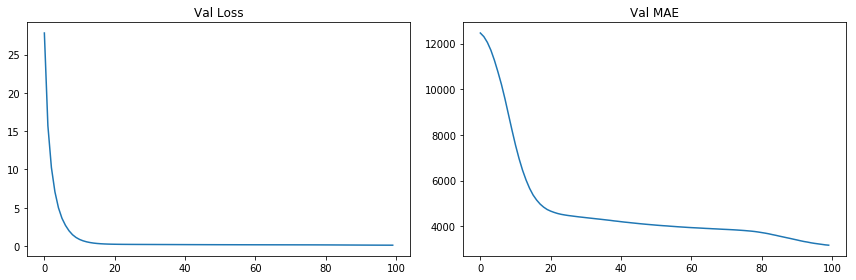

In [129]:
import matplotlib.pyplot as plt
from IPython import display

train_loss_graph = [] 
train_mae_graph = [] 

val_loss_graph = [] 
val_mae_graph = [] 

for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
        
    train_loss_graph.append(train_loss / train_batches) 
    train_mae_graph.append(train_mae / train_batches) 
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)
        
        
        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        

    val_loss_graph.append(val_loss / val_batches) 
    val_mae_graph.append(val_mae / val_batches) 
          
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    
    display.clear_output(wait=True) 
    f, axes = plt.subplots(1, 2, figsize=(12, 4)) 

    axes[0].plot(val_loss_graph) 
    axes[0].set_title('Val Loss')
 
    axes[1].plot(val_mae_graph)
    axes[1].set_title('Val MAE')

    plt.tight_layout() 
    plt.show() 
    
    early_stopping(val_loss/val_batches, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Ran the task 2 model from the beginning to see if it could stop the training within the first 100 epochs. However, validation loss as well as val MAE were improving all the time with considerable difference between current and previous iterations (delta) as you can see especially on the val MAE plot. Therefore, early stopping had never been activated. If the MAE or val. loss had been known from the task, it would have been possible to use the early stopping by specifying the desirable boundary.